# Определение авторства статьи на основе нейронных сете
### Постановка задачи:
* ......
* ......

In [2]:
!unzip -u dataset.zip
print('Success')

Archive:  dataset.zip
Success


In [3]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D
import numpy as np
import pandas as pd
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


### Загрузка тестовых документов

In [4]:
#path = 'D:\Разработка\DataScience\Habrahabr'
path = 'Habrahabr/'
files = os.listdir(path)
data_frame = pd.DataFrame()

for file_name in files:
    file_obj = codecs.open(path + file_name, "r", "utf_8_sig" )
    file_temp = file_obj.read()
    url = file_temp[file_temp.find('url:') + 5:file_temp.find('title:')].rstrip()
    title = file_temp[file_temp.find('title:') + 7:file_temp.find('text:')].rstrip()
    text = file_temp[file_temp.find('text:') + 5:file_temp.find('author:')].rstrip()
    author = file_temp[file_temp.find('author:') + 8:].rstrip()
    row = pd.Series([url, title, text, author], index=['Url', 'Title', 'Text', 'Author'])
    data_frame = data_frame.append(row, ignore_index=True)
    file_obj.close()

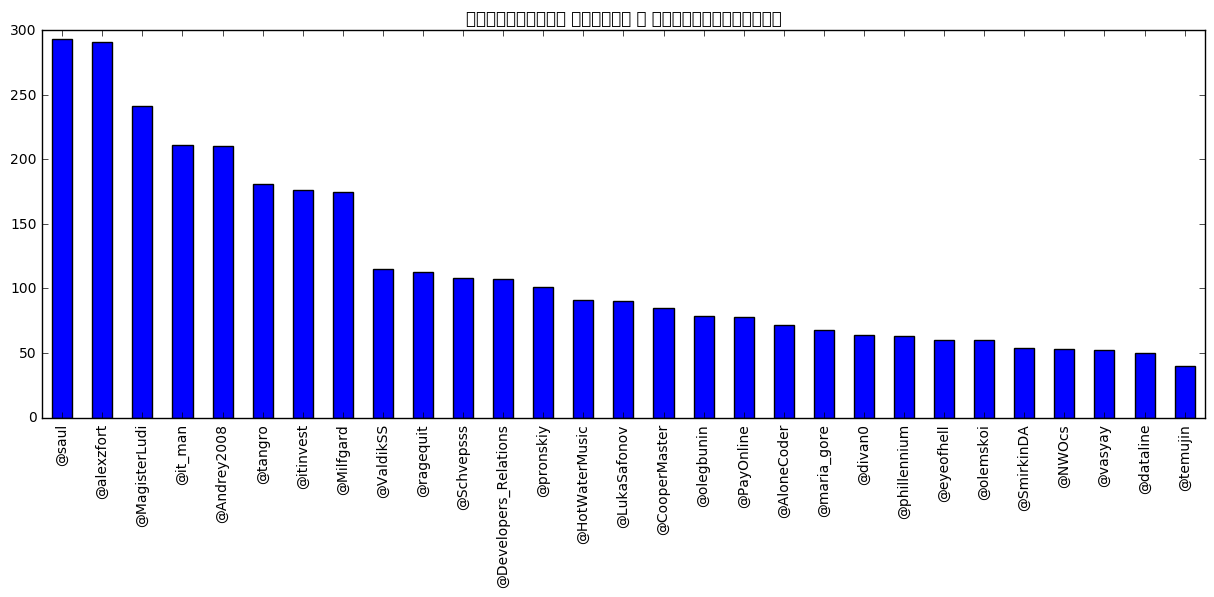

In [5]:
author_count_news = data_frame.Author.value_counts()[1:30]
author_count_news.plot(kind='bar', figsize=(15, 5), title='Количество статей у пользователей')

### Подготовка данных для анализа
- Добавление только топ 30 авторов
- Удаление столбцов URL, Title
- One hot encoding для результирующей выборки

In [6]:
data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    data = data.append(data_frame[data_frame.Author == author])

oneHotEnc = OneHotEncoder()
lableEnc = LabelEncoder()

lableEnc.fit(names_author.ravel()) 
lables = lableEnc.transform(names_author).reshape((29, 1))
oneHotEnc.fit(lables)

#aaa = lableEnc.transform(['@saul'])
#vvv = oneHotEnc.transform(aaa).toarray()
#print(vvv)

for author in names_author:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data = data.drop(['Url', 'Title'], axis=1)
data.head()

,Author,Text
1,25,"В шестой части серии учебных материалов, посв..."
23,25,С каждым новом поколением процессоры Intel вб...
25,25,Статья в блоге Intel «Прокачай свой жесткий д...
27,25,Испанская компания с говорящим названием Geek...
32,25,igzip — высокопроизводительная библиотека для...


### Производим векторизацию текста с помощью TF-IDF

In [7]:
texts = data['Text']
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r', split=" ", lower=True)
tokenizer.fit_on_texts(texts)
matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
print(matrix_tfidf.shape)

(3381, 5000)


### Разбиваем выборку на тестовую и тренировочную

In [8]:
X = matrix_tfidf
y = oneHotEnc.transform(data.Author.values.reshape(-1, 1)).toarray()

### Создание модели нейронной сети

In [9]:
model = Sequential()
# Слой для векторного представления слов
model.add(Embedding(max_features, 32))
model.add(SpatialDropout1D(0.2))
# Слой долго-краткосрочной памяти
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
# Полносвязный слой
model.add(Dense(29, activation="sigmoid"))
# Копмилируем модель
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(X, y, batch_size=64, epochs=3, verbose=2, shuffle=True, validation_split=0.2)
# Проверяем качество обучения на тестовых данных
#scores = model.evaluate(X, y, batch_size=1000)
#print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

Train on 2704 samples, validate on 677 samples
Epoch 1/3
315s - loss: 0.3651 - acc: 0.9196 - val_loss: 0.1778 - val_acc: 0.9655
Epoch 2/3
316s - loss: 0.1335 - acc: 0.9655 - val_loss: 0.2202 - val_acc: 0.9655
Epoch 3/3
315s - loss: 0.1310 - acc: 0.9655 - val_loss: 0.2359 - val_acc: 0.9655


ResourceExhaustedError: OOM when allocating tensor with shape[1000,5000,400]
	 [[Node: lstm_1/concat_1 = ConcatV2[N=4, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/Reshape_3, lstm_1/Reshape_6, lstm_1/Reshape_9, lstm_1/Reshape_12, lstm_1/concat_1/axis)]]
	 [[Node: Mean_5/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_883_Mean_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'lstm_1/concat_1', defined at:
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-f3a64dbbc620>", line 6, in <module>
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py", line 469, in add
    output_tensor = layer(self.outputs[0])
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/recurrent.py", line 262, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/recurrent.py", line 333, in call
    preprocessed_input = self.preprocess_input(inputs, training=None)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/recurrent.py", line 1087, in preprocess_input
    return K.concatenate([x_i, x_f, x_c, x_o], axis=2)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1723, in concatenate
    return tf.concat([to_dense(x) for x in tensors], axis)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1048, in concat
    name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 495, in _concat_v2
    name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1000,5000,400]
	 [[Node: lstm_1/concat_1 = ConcatV2[N=4, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/Reshape_3, lstm_1/Reshape_6, lstm_1/Reshape_9, lstm_1/Reshape_12, lstm_1/concat_1/axis)]]
	 [[Node: Mean_5/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_883_Mean_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("model/habra_model_2.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("model/habra_model_weights_2.h5")